In [1]:
import numpy as np
import scipy
import scipy.stats as st
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from astroML.stats.random import bivariate_normal

In [2]:
K = int(input("Enter the total number of bivariate Gaussian Distributions (K): "))
sigma_input = input("Enter the standard deviation of the proposal (sigma): ")
n = input("Enter the number of samples (n): ")

Enter the total number of bivariate Gaussian Distributions (K): 30000
Enter the standard deviation of the proposal (sigma): 1
Enter the number of samples (n): 100


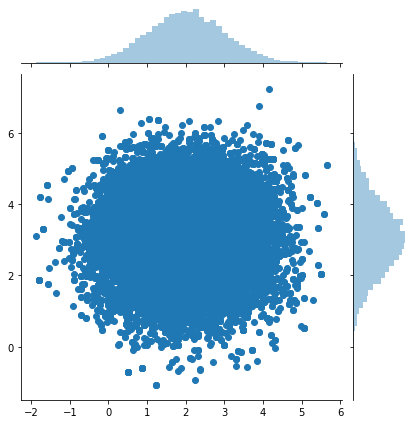

In [3]:
mus = np.empty ((0,2),float)
sigmas = np.empty ((0,2),float)

for x in range (1,K+1):
    mus = np.append(mus,np.array([[2*x,3*x]]), axis = 0)
    sigmas = np.append(sigmas,np.array([[np.sqrt(x),0],[0,np.sqrt(x)]]), axis = 0)


def pgauss(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mus[(0)], cov=sigmas[0:2])

def gaussian_plot(p, iter=K):
    x, y = 0., 0.
    samples = np.zeros((iter, 2))

    for i in range(iter):
        x_star, y_star = np.array([x, y]) + np.random.normal(size=2)
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star
        samples[i] = np.array([x, y])

    return samples  

samples = gaussian_plot(pgauss, iter=K)
sns.jointplot(samples[:, 0], samples[:, 1])


-0.005232938683716151

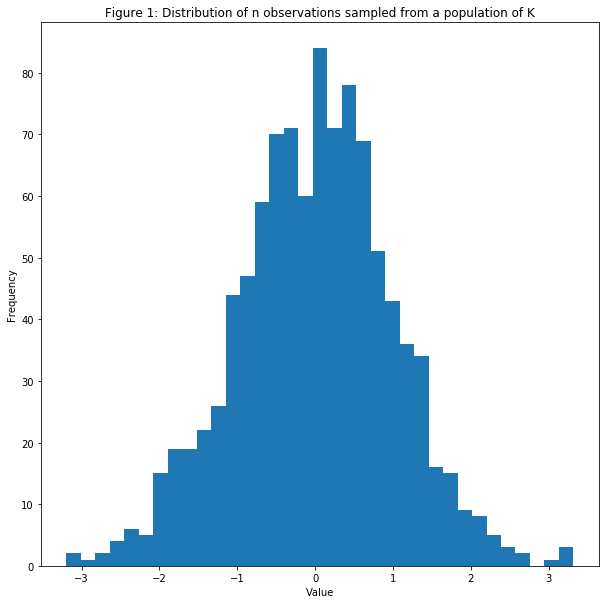

In [4]:
pop_mod = lambda t:np.random.normal(0,1,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = pop_mod(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of n observations sampled from a population of K")
mu_obs=observation.mean()
mu_obs

In [5]:
#The tranistion model defines how to move from sigma_current to sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    if(x[1] <=0):
        return 0
    return 1

def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [6]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)


C:\Users\Shubhadeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':
C:\Users\Shubhadeep\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log


(2908, 2)

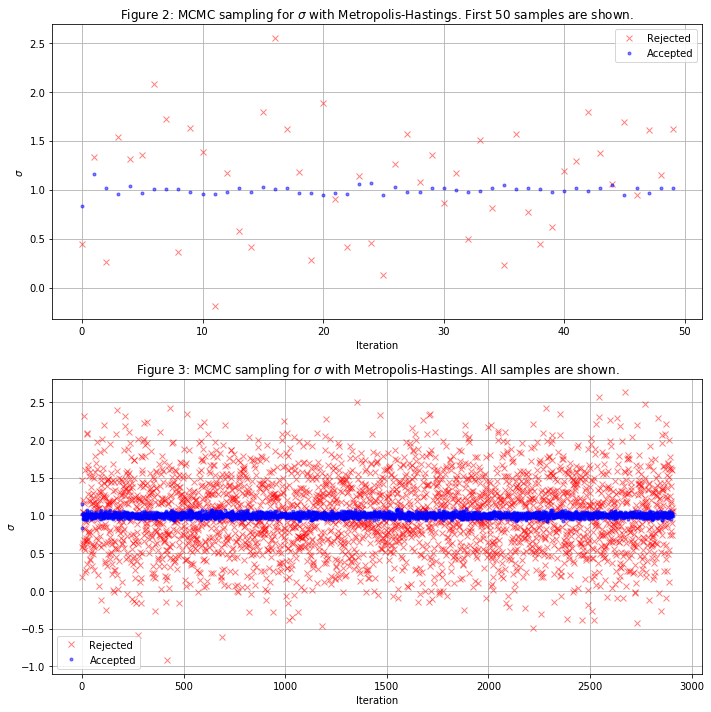

In [7]:
show=int(-0.5*accepted.shape[0])
hist_show=int(-0.50*accepted.shape[0])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

-0.005232938683716152 1.0011439793902632


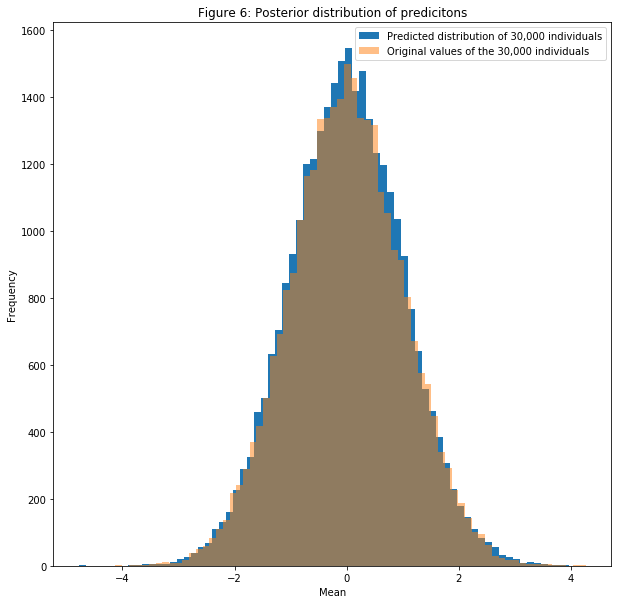

In [8]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist( population,bins=70 ,alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()